In [51]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
# -----------------------------
# 1) Load file + extract filename
# -----------------------------
filepath = "DCR Aug'25.xlsx"
df = pd.read_excel(filepath)

filename = os.path.basename(filepath)
print("Loaded file:", filename)
df.sample(5)

Loaded file: DCR Aug'25.xlsx


,CGI,pincode,district,Service Provider,LSA Code,Metric,technology,month,year,2025-08-01 00:00:00,...,2025-08-22 00:00:00,2025-08-23 00:00:00,2025-08-24 00:00:00,2025-08-25 00:00:00,2025-08-26 00:00:00,2025-08-27 00:00:00,2025-08-28 00:00:00,2025-08-29 00:00:00,2025-08-30 00:00:00,2025-08-31 00:00:00
19071,405-55-132840-22,193504,627,Airtel,JK,MV_VoLTE DCR_Nom [CBBH],4G,8,2025,0,...,0.002457,0,0,0,0.001916,0.00188,0,0,0,0
43620,405-55-392090-32,182204,620,Airtel,JK,MV_VoLTE DCR_Nom [CBBH],4G,8,2025,0,...,0,0,0.025641,0.007576,0,0,0.014286,0,0,0
47891,405-55-902272-13,180001,5,Airtel,JK,MV_VoLTE DCR_Nom [CBBH],4G,8,2025,0,...,0,0,0,0,0,0,0,0.008032,0,0
68446,405-55-151-45161,191131,623,Airtel,JK,Drop Call Rate_ Nom [BBH],2G,8,2025,0,...,0.003559,0,0,0,0,0.001229,0,0,0,0.002387
44258,405-55-901180-22,181221,627,Airtel,JK,MV_VoLTE DCR_Nom [CBBH],4G,8,2025,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df.columns

Index([              'CGI',           'pincode',          'district',
        'Service Provider',          'LSA Code',            'Metric',
              'technology',             'month',              'year',
       2025-08-01 00:00:00, 2025-08-02 00:00:00, 2025-08-03 00:00:00,
       2025-08-04 00:00:00, 2025-08-05 00:00:00, 2025-08-06 00:00:00,
       2025-08-07 00:00:00, 2025-08-08 00:00:00, 2025-08-09 00:00:00,
       2025-08-10 00:00:00, 2025-08-11 00:00:00, 2025-08-12 00:00:00,
       2025-08-13 00:00:00, 2025-08-14 00:00:00, 2025-08-15 00:00:00,
       2025-08-16 00:00:00, 2025-08-17 00:00:00, 2025-08-18 00:00:00,
       2025-08-19 00:00:00, 2025-08-20 00:00:00, 2025-08-21 00:00:00,
       2025-08-22 00:00:00, 2025-08-23 00:00:00, 2025-08-24 00:00:00,
       2025-08-25 00:00:00, 2025-08-26 00:00:00, 2025-08-27 00:00:00,
       2025-08-28 00:00:00, 2025-08-29 00:00:00, 2025-08-30 00:00:00,
       2025-08-31 00:00:00],
      dtype='object')

In [53]:
cols = list(df.columns)
original_cols = cols.copy()

# Replace columns from index 10 onward with 1..31
cols[9:] = np.arange(1, 32)  # --> change according to month days
df.columns = cols

date_cols = df.columns[9:]

# -----------------------------
# 3) Compute Result value per row
# -----------------------------
def process_row(row):
    values = row[date_cols]

    # Extract strings (e.g., "A", "OK", etc.)
    strings = [v for v in values if isinstance(v, str)]
    if strings:
        return strings[0]

    # Numeric average if numbers present
    nums = [v for v in values if isinstance(v, (int, float))]
    return sum(nums) / len(nums) if nums else None

df["Result"] = df.apply(process_row, axis=1)
df["num_Result"] = pd.to_numeric(df["Result"], errors="coerce")

# -----------------------------
# 4) Create Result_bin categories
# -----------------------------
bins = [0, 0.1, 1, float("inf")]
labels = ["Best DCR", "Variable DCR", "Worst DCR"]

df["Result_bin"] = pd.cut(
    df["num_Result"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

# Fallback: keep original string result where bin is NaN
df["Result_bin"] = df.apply(
    lambda row: row["Result"] if pd.isna(row["Result_bin"]) else row["Result_bin"],
    axis=1
)

# Force object dtype (safe)
df["Result_bin"] = df["Result_bin"].astype(object)

# -----------------------------
# 5) Balanced sampling method
#    Ensures: all districts, all pincodes, all tech, all Result_bin appear
# -----------------------------

stratified_cols = ["pincode", "district", "technology", "Result_bin"]

def ensure_all_categories(df, col):
    """Take 1 sample per category in this column."""
    return df.groupby(col).sample(n=1, random_state=24)

blocks = []

# Add a row for every unique category in each stratified column
for col in stratified_cols:
    blocks.append(ensure_all_categories(df, col))

base_sample = pd.concat(blocks).drop_duplicates()
print("Guaranteed coverage rows:", len(base_sample))

# -----------------------------
# 6) Fill the rest to reach 2000 rows
# -----------------------------
target_count = 2000
remaining = target_count - len(base_sample)

extra_sample = df.drop(base_sample.index).sample(
    n=remaining,
    random_state=52
)

sampled_data = pd.concat([base_sample, extra_sample])
sampled_data = sampled_data.sample(frac=1, random_state=99).reset_index(drop=True)  # shuffle

print("Final sample count:", len(sampled_data))
sampled_data.drop(columns='num_Result', index=0, inplace=True)
sampled_data.to_excel(f'sampled-{filename}', index=False)

Guaranteed coverage rows: 239
Final sample count: 2000


In [54]:
print(df['district'].value_counts().count())
print(df['pincode'].value_counts().count())
print(df['technology'].value_counts().count())
print(df['Result_bin'].value_counts().count())

22
212
2
3


In [55]:
print(sampled_data['district'].value_counts().count())
print(sampled_data['pincode'].value_counts().count())
print(sampled_data['technology'].value_counts().count())
print(sampled_data['Result_bin'].value_counts().count())

22
212
2
3


In [56]:
print(df['Result_bin'].value_counts())
print(sampled_data['Result_bin'].value_counts())

Result_bin
Best DCR        67436
DNE             12162
Variable DCR       34
Name: count, dtype: int64
Result_bin
Best DCR        1670
DNE              328
Variable DCR       1
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='Result_bin'>

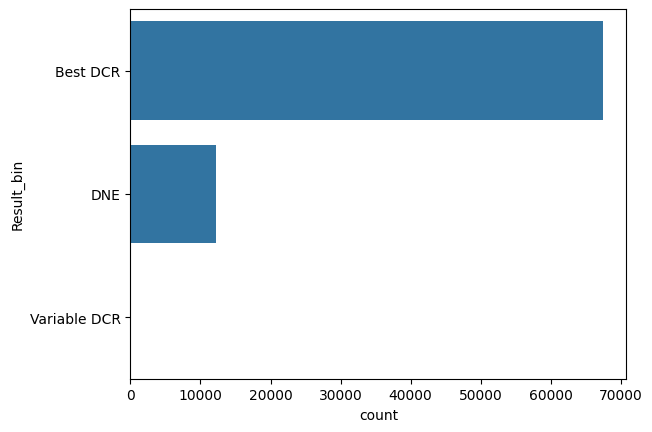

In [57]:
sns.countplot(df['Result_bin'])

<Axes: xlabel='count', ylabel='Result_bin'>

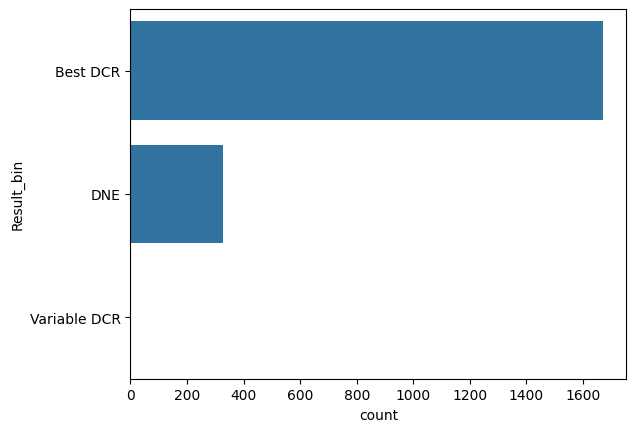

In [58]:
sns.countplot(sampled_data['Result_bin'])